In [ ]:
# #this mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# # enter the foldername in the Shared Google Drive
# FOLDERNAME = 'Shared drives/SemEval 2021'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/{}'.format(FOLDERNAME))

# %cd /content/drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/Shared drives/SemEval 2021


In [ ]:
pip install textstat

     |████████████████████████████████| 102kB 3.7MB/s 
     |████████████████████████████████| 1.9MB 7.1MB/s 


In [ ]:
import pandas as pd
import numpy as np
from torchtext.vocab import GloVe
import time
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor 
from mlxtend.regressor import StackingCVRegressor

import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, GroupKFold
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr
import textstat
import h5py



In [ ]:
def count_numbers(s):
  return sum([int(x.isdigit()) for x in s])

assert count_numbers('53177aa') == 5

In [ ]:
print("Loading GloVe embeddings...")
glove = GloVe(cache='./GloVe')

Loading GloVe embeddings...


In [ ]:
frequencies = pd.read_csv('datasets/unigram_prob_2.csv', keep_default_na=False, names=['word', 'freq'])
word_to_freq = {}
for _, row in frequencies.iterrows():
  word_to_freq[row['word']] = row['freq']
def freq(s):
  return word_to_freq.get(s, 1e-8)

In [ ]:
def count_capitals(s):
  return sum([int(x.upper() == x) for x in s])

assert count_capitals('ABCdefg') == 3


In [ ]:
scaler = StandardScaler()
pca_dim = 100
pca_sent_dim=10
pca = PCA(n_components=pca_dim)
pca_sent = PCA(n_components=pca_sent_dim)

def load_data(filename, scale=False):
  df = pd.read_csv(filename, delimiter='\t"|\t', keep_default_na=False)
  df = pd.read_csv(filename, delimiter='\t"|\t', keep_default_na=False)

  glove_vecs = df.apply(lambda row: glove[row['token']].numpy(), axis=1)
  print("Processing GloVe word vectors.")
  sent_vecs = df.apply(lambda row: np.mean(np.stack([glove[token].numpy() for token in row['sentence'].split()]), axis=0), axis=1)
  print("Processing GloVe sentence vectors.")
  
  stanza_fname = 'datasets/trial_stanza.tsv' if 'trial' in filename else 'datasets/train_stanza.tsv'
  
  KEYS = {
    'freq': (lambda row: freq(row['token'])),
    'log_freq': (lambda row: np.log(freq(row['token']))),
    'in_corpus': (lambda row: row['token'] in word_to_freq),
    'num_numbers_sent': (lambda row: count_numbers(str(row['sentence']))),
    'num_capitals': (lambda row: count_capitals(str(row['token']))),
    'frac_capitals': (lambda row: count_capitals(str(row['token'])) / len(row['token'])),
    'syllables': (lambda row: textstat.syllable_count(str(row['token']))),
    'bible': (lambda row: row['corpus'] == 'bible'),
    'biomed': (lambda row: row['corpus'] == 'biomed'),
    'biomed-long': (lambda row: int(row['corpus'] == 'biomed')*len(row['token'])),
    'biomed-numbers': (lambda row: int(row['corpus'] == 'biomed')*count_numbers(row['sentence'])),
    'sentence_len': (lambda row: len(row['sentence'].split())),
    # 'europarl': (lambda row: row['corpus'] == 'europarl'), # colinearity
    'len_token': (lambda row: len(row['token'])),
    'first_letter_is_capital': (lambda row: count_capitals(row['token'][0])),
  #  'in_glove': (lambda row: row['token'] in glove.freqs)
  #  'flesch': (lambda row: textstat.flesch_reading_ease(str(row['token'])))
  }
  # max_value = max(word_to_freq.values())
  # df['freq'] = df.apply(lambda row: word_to_freq.get(row['token'], max_value), axis=1)
  
  
  data_orig = np.concatenate([np.stack(glove_vecs.tolist())], axis=-1)
  if 'train' in filename:
    data = pca.fit_transform(data_orig)
  else:
    data = pca.transform(data_orig)
    
  data_orig_sent = np.concatenate([np.stack(sent_vecs.tolist())], axis=-1)
  if 'train' in filename:
    data_sent = pca_sent.fit_transform(data_orig_sent)
  else:
    data_sent = pca_sent.transform(data_orig_sent)
    
  data = np.concatenate([data, data_sent], axis=-1)
  print("data shape after transformation:", data.shape)
  data = pd.DataFrame(data=data, columns=[f'glove{i}' for i in range(pca_dim)] + [f'sent{i}' for i in range(pca_sent_dim)])
  
  for key, func in KEYS.items():
    data[key] = df.apply(func, axis=1)
    
  # data['log_freq'] = np.log(data['freq'])
  
  stanza_df = pd.read_csv(stanza_fname, delimiter='\t')
  data['is_propn'] = stanza_df['upos'].apply(lambda x: x == 'PROPN')
  data['is_ner'] = stanza_df['ner'].apply(lambda x: x != 'O')
  
  print("Final dimensionality:", data.shape)

  if scale:
    scalable_columns = data.columns # [col for col in data.columns if 'glove' not in col and 'sent' not in col]
    print("Scaling:", scalable_columns)
    if 'train' in filename:
      scaler.fit(data[scalable_columns])
    print(scaler.mean_)

    data[scalable_columns] = scaler.transform(data[scalable_columns])
    #data[:, -len(inputs):] = scaler.transform(data[:, -len(inputs):])
    print(data.shape)
  return data, df['complexity'].values

In [ ]:
df_train = pd.read_csv('datasets/lcp_single_train.tsv', delimiter='\t"|\t', keep_default_na=False)
df_trial = pd.read_csv('datasets/lcp_single_trial.tsv', delimiter='\t"|\t', keep_default_na=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [ ]:
data_train, complexity_train = load_data('datasets/lcp_single_train.tsv', scale=True)
data_trial, complexity_trial = load_data('datasets/lcp_single_trial.tsv', scale=True)
# mut_train = mutual_info_regression(data_train, complexity_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


Processing GloVe word vectors.
Processing GloVe sentence vectors.
data shape after transformation: (7662, 110)
Final dimensionality: (7662, 126)
Scaling: Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
[-1.43751112e-07  1.58032857e-06  3.57341890e-07 -1.22816767e-06
  6.87943194e-07 -1.31375911e-06 -4.43154952e-07  6.98301628e-08
  7.59705780e-07 -4.04419929e-07  9.06398892e-07 -4.87771652e-07
 -3.38551164e-07 -2.13462493e-07  1.74581281e-07  9.85851544e-08
 -5.57668448e-07  1.61923966e-07 -5.39329023e-07 -3.13882752e-07
  1.25583260e-07 -1.54820797e-07  1.48478472e-07 -8.10181840e-08
  3.95851568e-07 -4.87414553e-07  3.06651262e-07 -7.88357557e-08
 -1.63694762e-07 -1.56520976e-09  2.41653925e-07 -1.51668689e-07
 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


Final dimensionality: (421, 126)
Scaling: Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
[-1.43751112e-07  1.58032857e-06  3.57341890e-07 -1.22816767e-06
  6.87943194e-07 -1.31375911e-06 -4.43154952e-07  6.98301628e-08
  7.59705780e-07 -4.04419929e-07  9.06398892e-07 -4.87771652e-07
 -3.38551164e-07 -2.13462493e-07  1.74581281e-07  9.85851544e-08
 -5.57668448e-07  1.61923966e-07 -5.39329023e-07 -3.13882752e-07
  1.25583260e-07 -1.54820797e-07  1.48478472e-07 -8.10181840e-08
  3.95851568e-07 -4.87414553e-07  3.06651262e-07 -7.88357557e-08
 -1.63694762e-07 -1.56520976e-09  2.41653925e-07 -1.51668689e-07
 -1.29561951e-07  3.26185207e-07  1.08612616e-07  1.23280278e-07
  2.01820206e-07 -3.50987289e-07 -1.78223955e-07 

In [ ]:
data_train[data_train['frac_capitals'] > 1]

,glove0,glove1,glove2,glove3,glove4,glove5,glove6,glove7,glove8,glove9,glove10,glove11,glove12,glove13,glove14,glove15,glove16,glove17,glove18,glove19,glove20,glove21,glove22,glove23,glove24,glove25,glove26,glove27,glove28,glove29,glove30,glove31,glove32,glove33,glove34,glove35,glove36,glove37,glove38,glove39,...,glove86,glove87,glove88,glove89,glove90,glove91,glove92,glove93,glove94,glove95,glove96,glove97,glove98,glove99,sent0,sent1,sent2,sent3,sent4,sent5,sent6,sent7,sent8,sent9,freq,log_freq,in_corpus,num_numbers_sent,num_capitals,frac_capitals,syllables,bible,biomed,biomed-long,biomed-numbers,sentence_len,len_token,first_letter_is_capital,is_propn,is_ner
234,1.736268,-0.416352,-0.297509,-1.254850,-2.227863,0.453226,1.211072,0.518260,0.178544,0.863434,-0.331683,-0.234587,1.098627,-0.007628,0.568076,-0.225068,-1.597614,-0.325855,1.954798,0.120371,0.136984,-0.659078,1.734477,1.161751,0.908647,-0.220340,-0.998616,0.868142,-0.114704,0.192222,0.547447,0.487175,-0.123673,0.071364,-0.394072,0.917591,-0.593237,-0.475392,0.941111,-1.772895,...,-0.605624,-0.125599,-0.731760,1.005470,-0.096238,-0.335345,-1.088947,-1.121332,0.671299,-1.777143,1.536448,-0.458894,0.234310,-0.916989,-0.897788,0.254552,0.038166,-2.130400,-1.233095,0.659619,1.036790,0.805282,0.304814,1.634543,-0.409843,-0.721947,-0.735758,-0.403953,1.440881,1.712702,-1.049999,1.405948,-0.71168,-0.642,-0.374535,-0.851997,-1.618789,1.940342,-0.420879,2.253027
368,1.023792,-0.552114,-0.289752,-1.548417,-1.441161,0.761935,0.357813,-0.056577,0.318461,-0.142844,0.879796,-0.388654,-0.019457,0.398739,-0.203838,1.293299,-0.450806,-0.734158,0.115023,0.307566,1.406673,-0.084219,1.789149,0.689690,0.345024,-1.033560,0.018976,-0.717587,0.634331,0.027992,-2.217182,0.344574,-1.413329,-1.916839,-0.856908,0.050608,-0.546560,-1.431088,0.493873,-0.123733,...,-0.841350,-0.825474,1.269795,-0.324558,0.509758,-1.453963,0.548510,0.434095,-0.501587,-0.378079,-0.776905,1.131164,0.743551,-0.061971,-1.391936,-1.049272,0.866026,-1.593736,-2.812763,0.936263,0.986982,-1.151158,0.326076,1.850581,-0.409843,-0.721947,-0.735758,-0.403953,1.440881,1.712702,-1.049999,1.405948,-0.71168,-0.642,-0.374535,-0.921652,-1.618789,1.940342,2.375978,2.253027
506,1.340982,-0.985667,-0.014117,-1.495081,-1.308658,0.508023,0.833595,-0.164345,-0.283075,0.985095,-0.552942,-0.692619,0.600252,-0.262492,0.371642,-0.912357,-0.064019,0.789944,-0.015778,-0.763187,0.182302,-1.928650,-0.250705,-1.085538,-1.016370,-0.521914,-1.432810,-1.684333,0.380103,-0.594689,-0.158923,0.900913,-0.467174,1.622937,1.171578,1.161826,-0.158418,-0.773477,-0.294637,-0.581183,...,-0.532442,0.468799,0.115156,0.406339,0.187519,1.228868,1.198932,-0.684695,-1.290603,-0.175877,-0.213192,0.711298,1.160161,1.639793,-1.012037,-0.499385,1.363032,0.551570,0.486308,-0.653800,0.994946,0.031403,0.940692,0.731839,0.329445,1.389594,1.359143,-0.403953,1.440881,1.201401,-1.049999,1.405948,-0.71168,-0.642,-0.374535,-0.503726,-1.245064,1.940342,-0.420879,-0.443847
507,1.340982,-0.985667,-0.014117,-1.495081,-1.308658,0.508023,0.833595,-0.164345,-0.283075,0.985095,-0.552942,-0.692619,0.600252,-0.262492,0.371642,-0.912357,-0.064019,0.789944,-0.015778,-0.763187,0.182302,-1.928650,-0.250705,-1.085538,-1.016370,-0.521914,-1.432810,-1.684333,0.380103,-0.594689,-0.158923,0.900913,-0.467174,1.622937,1.171578,1.161826,-0.158418,-0.773477,-0.294637,-0.581183,...,-0.532442,0.468799,0.115156,0.406339,0.187519,1.228868,1.198932,-0.684695,-1.290603,-0.175877,-0.213192,0.711298,1.160161,1.639793,-0.542285,0.562382,0.764577,-0.217631,1.374482,-0.802421,-1.010216,0.560506,1.186692,0.304363,0.329445,1.389594,1.359143,-0.403953,1.440881,1.201401,-1.049999,1.405948,-0.71168,-0.642,-0.374535,-1.060960,-1.245064,1.940342,-0.420879,2.253027
524,1.821646,-0.543827,-1.862365,0.904987,-2.568617,-0.003990,2.211259,1.305592,0.752655,2.545342,0.822121,1.109573,0.042106,0.203174,-0.608794,1.078455,-2.077626,-0.188954,0.124181,0.257279,-0.870825,-0.396300,0.954410,0.382773,0.101201,0.477734,-0.045659,1.22

(array([6.826e+03, 5.880e+02, 1.540e+02, 5.000e+01, 1.200e+01, 2.600e+01,
        3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([-0.37453478,  1.12949326,  2.63352129,  4.13754933,  5.64157737,
         7.14560541,  8.64963344, 10.15366148, 11.65768952, 13.16171756,
        14.66574559]),
 <a list of 10 Patch objects>)

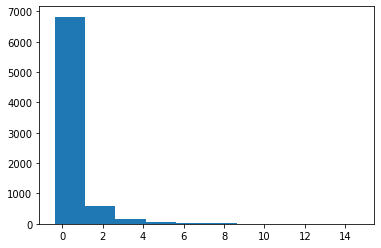

In [ ]:
plt.hist(data_train['biomed-numbers'])

In [ ]:
class CorpusWrapper:
  def __init__(self, corpus, regressor, group_weight):
    self.regressor = clone(regressor) # .copy()
    self.corpus = corpus
    self.group_weight = group_weight

  def fit(self, X, y, corpus_data):
    idx = (corpus_data == self.corpus)
    intercept = 0 if self.group_weight == -1 else 1
    weight = intercept + idx * (1 if self.group_weight == -1 else self.group_weight)
    self.regressor.fit(X, y, sample_weight=weight)

  def predict(self, X):
    return self.regressor.predict(X)

In [ ]:
class GroupRegressor:
  def __init__(self, regressor, group_weight):
    self.regressor = regressor
    self.corpus_to_regressor = {}
    self.group_weight = group_weight
    
  def fit(self, X, y, corpus_data):
    for corpus in np.unique(corpus_data):
      self.corpus_to_regressor[corpus] = CorpusWrapper(corpus, self.regressor, self.group_weight)
      self.corpus_to_regressor[corpus].fit(X, y, corpus_data)

  def predict(self, X, corpus_data):
    out = np.zeros(len(X))
    for corpus, reg in self.corpus_to_regressor.items():
      idx = (corpus_data == corpus)
      y_pred = reg.predict(X[idx])
      out[idx] = y_pred
    return out

In [ ]:
import scipy.special
def run_experiment(regressor, dim=None, drop_cols=None, scale=False, group_weight=0):
  if dim is not None:
    pca = PCA(n_components=dim)
    training_data = pca.fit_transform(data_train)
    trial_data = pca.transform(data_trial)
  else:
    training_data = data_train
    trial_data = data_trial
    
  if drop_cols is not None:
    training_data = training_data.drop(drop_cols, axis=1)
    trial_data = trial_data.drop(drop_cols, axis=1)
    
  print("After dropping", training_data.shape)
  print(training_data.columns)
#   print(training_data['log_freq'])
#   print(training_data['bible'])
#   print(training_data['glove0'])
  
  def forward(x):
    return scipy.special.logit(x+0.1)

  def backward(x):
    return scipy.special.expit(x)-0.1
    
  # kf = KFold(n_splits=10)
  # kf = ShuffleSplit(n_splits=5)
  kf = GroupKFold(n_splits=5)
  cvcs = []
  for train_idx, test_idx in kf.split(training_data, complexity_train, df_train['token']):
      #weight = 1 + (df_train.to_numpy()[train_idx]['corpus'] == 'europarl').squeeze()
      if group_weight != 0:
        reg = GroupRegressor(regressor, group_weight)
        reg.fit(training_data.iloc[train_idx], forward(complexity_train[train_idx]), df_train.iloc[train_idx]['corpus'])
        predictions = backward(reg.predict(training_data.iloc[test_idx], df_train.iloc[test_idx]['corpus']))
      else:
        reg = regressor
        if isinstance(reg, StackingCVRegressor):
          print("Fitting with StackingCVRegressor; passing groups.")
          reg.fit(training_data.iloc[train_idx], forward(complexity_train[train_idx]), df_train.iloc[train_idx]['token'])
        else:
          reg.fit(training_data.iloc[train_idx], forward(complexity_train[train_idx]))
        predictions = backward(reg.predict(training_data.iloc[test_idx]))
      
      cvc = pearsonr(predictions, complexity_train[test_idx])[0]
#       print("Cross-val complexity:", cvc)
      cvcs.append(cvc)
  print("Cross-val:", np.mean(cvcs), cvcs)
#   reg = GroupRegressor(regressor, group_weight) if group_weight != 0 else regressor
#   scores = cross_val_score(reg, training_data, forward(complexity_train),
#                            scoring=make_scorer(lambda y, y_pred: pearsonr(y, y_pred)[0]), cv=GroupKFold(n_splits=5), groups=df_train['token'])
#   print(scores.mean(), scores)

  if group_weight != 0: 
    print("Fitting a GroupRegressor.")
    regressor = GroupRegressor(regressor, group_weight)
    regressor.fit(training_data, forward(complexity_train), df_train['corpus'])
    predictions = backward(regressor.predict(training_data, df_train['corpus']))
    trial_predictions = backward(regressor.predict(trial_data, df_trial['corpus']))
  else:
    print("Fitting a single regressor.")
    if isinstance(regressor, StackingCVRegressor):
      regressor.fit(training_data, forward(complexity_train), df_train['token'])
    else:
      regressor.fit(training_data, forward(complexity_train))
    
    predictions = backward(regressor.predict(training_data))
    trial_predictions = backward(regressor.predict(trial_data))
  
  print("Train R", pearsonr(complexity_train, predictions))
  print("Train L1:", np.mean(np.abs(predictions - complexity_train)))
  print("Trial R", pearsonr(complexity_trial, trial_predictions))
  print("Trial L1:", np.mean(np.abs(trial_predictions - complexity_trial)))
  
  for corpus in np.unique(df_trial['corpus']):
    idx = (df_trial['corpus'] == corpus)
    print(corpus, pearsonr(complexity_trial[idx], trial_predictions[idx]))
  
  colors = {'bible': 'red', 'biomed': 'green', 'europarl': 'blue'}
  
  plt.clf()
  plt.scatter(predictions, complexity_train, s=0.1, c=[colors[cat] for cat in df_train['corpus']], alpha=0.4)
  plt.plot(predictions, predictions, linewidth=2)
  plt.xlabel("Prediction on train set")
  plt.ylabel("Ground truth on train set")
  plt.show()
  
  plt.clf()
  plt.scatter(trial_predictions, complexity_trial, s=0.5) # , c=[colors[cat] for cat in df_trial['corpus']]
  plt.plot(predictions, predictions, linewidth=2)
  plt.xlabel("Prediction on trial set")
  plt.ylabel("Ground truth on trial set")
  plt.show()
  
  return trial_predictions, complexity_trial, predictions, complexity_train

After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
Cross-val: 0.7585918356816498 [0.7555657353082484, 0.7584905720479698, 0.7567443362638772, 0.7483188331817753, 0.7738397016063783]
Fitting a single regressor.
Train R (0.7759064585217751, 0.0)
Train L1: 0.0654144448233875
Trial R (0.7789090658823666, 6.2121519038502465e-87)
Trial L1: 0.06715051412167981
bible (0.7277548551640758, 7.397719398055211e-25)
biomed (0.8132558040678595, 4.495731212525328e-33)
europarl (0.7249440481950661, 1.3657704417709981e-24)


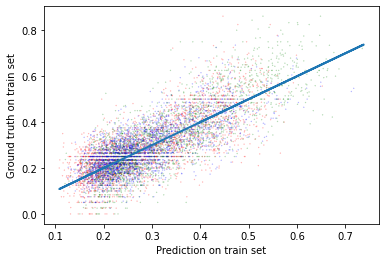

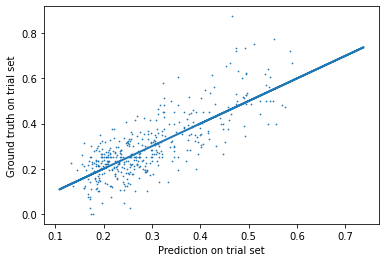

In [ ]:
reg = Ridge(alpha=0.0001)
trial_p, trial_c, train_p, train_c = run_experiment(reg) # , 'bible', 'biomed'])

After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
Cross-val: 0.7602845797555561 [0.759060162057254, 0.7600195386851473, 0.7649544020985801, 0.7426603167712476, 0.7747284791655519]
Fitting a GroupRegressor.
Train R (0.7955568649782437, 0.0)
Train L1: 0.06303630478550863
Trial R (0.7795777181861991, 3.560247321954171e-87)
Trial L1: 0.06645820711519192
bible (0.7249162797687446, 1.3740163446291754e-24)
biomed (0.7922253526916471, 2.5643333261078782e-30)
europarl (0.7528637216328159, 2.156854798835203e-27)


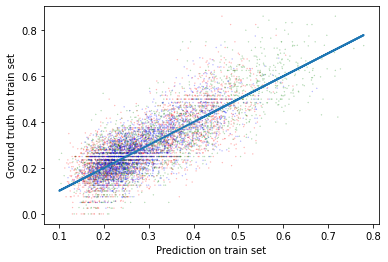

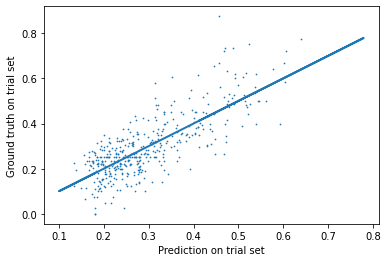

In [ ]:
reg = Ridge(alpha=0.00001)
trial_p, trial_c, train_p, train_c = run_experiment(reg, group_weight=10) # , 'bible', 'biomed'])

After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
Cross-val: 0.7534861190157587 [0.772436730335045, 0.7631548699495072, 0.7467634694742733, 0.7438726854445309, 0.741202839875437]
Fitting a GroupRegressor.
Train R (0.8752071351456949, 0.0)
Train L1: 0.05298852206551228
Trial R (0.8007111509445606, 2.7780505160341043e-95)
Trial L1: 0.06458876220309033
bible (0.7481283752881814, 6.835693306549211e-27)
biomed (0.8161996988828226, 1.7346297799402317e-33)
europarl (0.7512707152273163, 3.1886366183649596e-27)


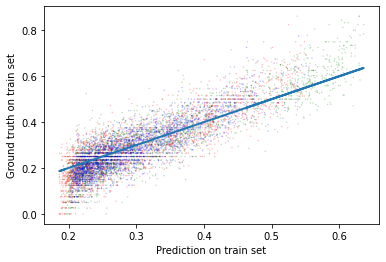

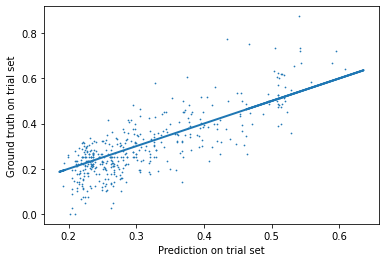

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(num_leaves=35, reg_lambda=200, max_depth=10, importance_type='gain', boosting_type='dart')
trial_p, trial_c, train_p, train_c = run_experiment(lgbm, group_weight=2) # , 'bible', 'biomed'])

After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
Cross-val: 0.7559725238067465 [0.7686364637985467, 0.7665286975737816, 0.7430981797772563, 0.7468319951241228, 0.7547672827600251]
Fitting a single regressor.
Train R (0.864588991445576, 0.0)
Train L1: 0.0549780695187941
Trial R (0.7958472884145139, 2.4785263904150225e-93)
Trial L1: 0.06577837448360796
bible (0.7282270194054239, 6.668712295329623e-25)
biomed (0.8180337428606211, 9.50105167158108e-34)
europarl (0.7502653819869142, 4.074692780703376e-27)


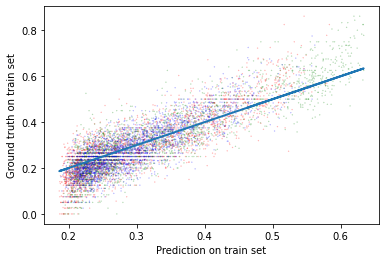

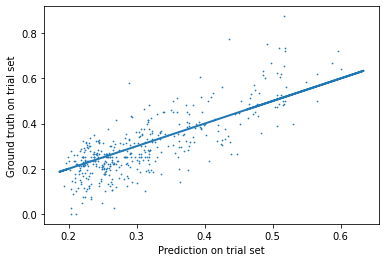

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(num_leaves=40, reg_lambda=50, max_depth=15, feature_fraction=0.75, importance_type='gain', boosting_type='dart')
trial_p, trial_c, train_p, train_c = run_experiment(lgbm) # , 'bible', 'biomed'])

After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
Cross-val: 0.7473682133583122 [0.7544784158641255, 0.756866662143789, 0.7612648563008239, 0.7296312780890517, 0.7345998543937712]
Fitting a single regressor.
Train R (0.9095797321437138, 0.0)
Train L1: 0.045375773748668614
Trial R (0.7913092672708532, 1.468120785279732e-91)
Trial L1: 0.06502616893847271
bible (0.7262655101734312, 1.0247113632033211e-24)
biomed (0.8223630587552011, 2.2325038350416507e-34)
europarl (0.718875581263718, 5.002575379193098e-24)


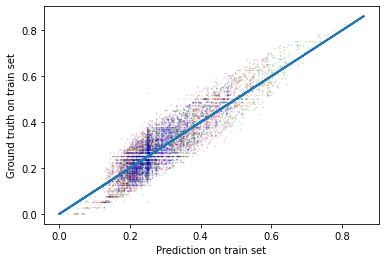

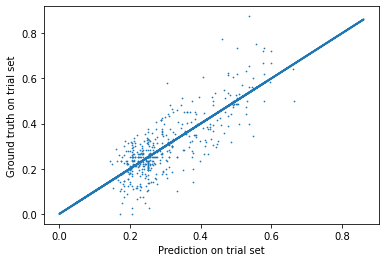

(array([0.17287288, 0.17287288, 0.17562844, 0.16021412, 0.20705917,
        0.20705917, 0.19199549, 0.19967619, 0.19117647, 0.17877712,
        0.15237736, 0.18018497, 0.1713987 , 0.17877712, 0.18433098,
        0.19303698, 0.19247901, 0.22704081, 0.2184563 , 0.22164831,
        0.23677863, 0.22772871, 0.17562844, 0.24697085, 0.33399089,
        0.319758  , 0.33399089, 0.22756449, 0.20928921, 0.20954723,
        0.21785141, 0.18362283, 0.18362283, 0.20446432, 0.20446432,
        0.20928921, 0.20928921, 0.20446432, 0.19552502, 0.19552502,
        0.19552502, 0.27631579, 0.27444726, 0.26622445, 0.26622445,
        0.26622445, 0.26622445, 0.18210038, 0.19673447, 0.30421058,
        0.20586312, 0.20586312, 0.21304709, 0.2051626 , 0.21304709,
        0.23509625, 0.27295521, 0.25152429, 0.25152429, 0.26251319,
        0.17847278, 0.20339434, 0.29472464, 0.28941781, 0.20643079,
        0.22428944, 0.23863841, 0.23863841, 0.23441693, 0.37722012,
        0.30283543, 0.2918519 , 0.2918519 , 0.29

In [ ]:
from sklearn.feature_selection import SelectFromModel
pipe = Pipeline([('select', SelectFromModel(LinearRegression(), threshold='mean')), 
          ('adaboost', AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=50))])
run_experiment(pipe)

In [ ]:
pipe.named_steps['select'].threshold_

After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
Cross-val: 0.746133774422092 [0.7593194729702881, 0.7502338495970821, 0.7595188361199512, 0.7307016213385517, 0.7308950920845874]
Fitting a single regressor.
Train R (0.903671896741417, 0.0)
Train L1: 0.046695151718600204
Trial R (0.7964068808565655, 1.4876522773660753e-93)
Trial L1: 0.06491686825717034
bible (0.7139880453337324, 1.388769096730828e-23)
biomed (0.8356438686122516, 2.0299766273819907e-36)
europarl (0.731833016913383, 2.997790570340098e-25)


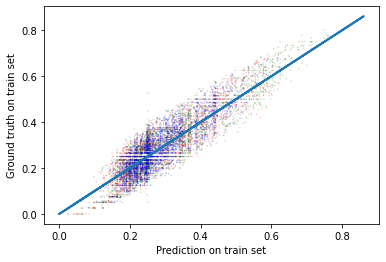

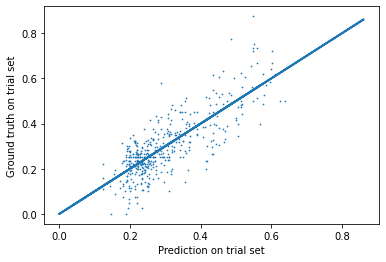

(array([0.14635403, 0.18645856, 0.12326428, 0.12504296, 0.19006943,
        0.19328431, 0.15796053, 0.19006943, 0.15796053, 0.19660883,
        0.20275982, 0.18066793, 0.20985507, 0.19660883, 0.18064013,
        0.20275982, 0.20275982, 0.2188812 , 0.19625317, 0.21306688,
        0.21417884, 0.19829947, 0.18126743, 0.25024274, 0.31036298,
        0.28736551, 0.31036298, 0.23822311, 0.21417884, 0.21935665,
        0.17288181, 0.18126743, 0.17860158, 0.2132586 , 0.21417884,
        0.21417884, 0.21616155, 0.21875   , 0.14352448, 0.14923793,
        0.17857143, 0.25282838, 0.2555111 , 0.296875  , 0.296875  ,
        0.296875  , 0.29378164, 0.17139568, 0.2       , 0.25309913,
        0.19055551, 0.19997093, 0.21027965, 0.1949377 , 0.19055551,
        0.23150665, 0.27380952, 0.27325015, 0.27325015, 0.25887968,
        0.1534417 , 0.21553996, 0.30392325, 0.296875  , 0.23374739,
        0.20194143, 0.22299918, 0.21417884, 0.21945141, 0.4156332 ,
        0.31944444, 0.28572603, 0.29347826, 0.31

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
pipe = Pipeline([('select', SelectFromModel(LinearRegression(), threshold=0.02)), 
          ('adaboost', AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=50))])
run_experiment(pipe)

In [ ]:
np.array(data_train.columns)[np.where(pipe.named_steps['select'].get_support())]

After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
Cross-val: 0.7374798425798976 [0.7486931164342794, 0.7390034948221196, 0.7512341323762038, 0.7121983747242805, 0.7362700945426048]
Fitting a single regressor.
Train R (0.9210601088250596, 0.0)
Train L1: 0.042503544554320594
Trial R (0.7819919047444152, 4.6933452931010055e-88)
Trial L1: 0.06636848023458682
bible (0.701608729258608, 1.680416195975703e-22)
biomed (0.813692152052647, 3.9080492015308664e-33)
europarl (0.7312130251798554, 3.4427252450157756e-25)


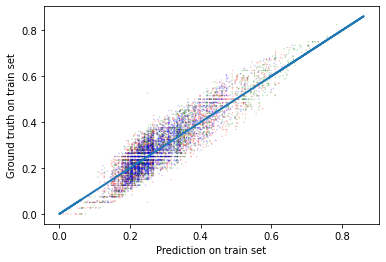

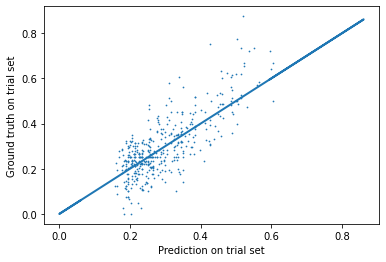

(array([0.20240293, 0.1950193 , 0.23327548, 0.1950193 , 0.18218901,
        0.18072707, 0.16263813, 0.18218901, 0.16263813, 0.20206234,
        0.20206234, 0.19547975, 0.1950193 , 0.20206234, 0.1950193 ,
        0.20634709, 0.20634709, 0.18744127, 0.18744127, 0.18744127,
        0.19405629, 0.19405629, 0.20596615, 0.24997093, 0.3311717 ,
        0.33823529, 0.3311717 , 0.23811069, 0.18930966, 0.17857307,
        0.22797061, 0.15620209, 0.16071429, 0.16210995, 0.21462323,
        0.21462323, 0.21462323, 0.21462323, 0.18826292, 0.1950193 ,
        0.18826292, 0.24128857, 0.23358801, 0.29811343, 0.29811343,
        0.29811343, 0.29811343, 0.21233223, 0.22566379, 0.26729144,
        0.21462323, 0.21462323, 0.21462323, 0.21462323, 0.21462323,
        0.23358801, 0.26221117, 0.26475849, 0.26475849, 0.26475849,
        0.1950193 , 0.20206234, 0.31596294, 0.31596294, 0.22325431,
        0.17857307, 0.18752706, 0.18752706, 0.23358801, 0.33516954,
        0.27745405, 0.27745405, 0.27335234, 0.27

In [ ]:
from sklearn.feature_selection import SelectFromModel
pipe = Pipeline([('select', SelectFromModel(LinearRegression(), threshold=0.01)), 
          ('adaboost', AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=21))])
run_experiment(pipe)

In [ ]:
from sklearn.feature_selection import SelectFromModel
pipe = Pipeline([('select', SelectFromModel(LinearRegression(), threshold=0.01)), 
          ('adaboost', AdaBoostRegressor(DecisionTreeRegressor(max_depth=12), n_estimators=20))])
run_experiment(pipe)

In [ ]:
from sklearn.feature_selection import SelectFromModel
pipe = Pipeline([('select', SelectFromModel(LinearRegression(), threshold=0.03)), 
          ('adaboost', AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=50))])
run_experiment(pipe)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(num_leaves=40, reg_lambda=50, path_smooth=1, max_depth=15, feature_fraction=0.75, importance_type='gain')
run_experiment(lgbm)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(num_leaves=40, reg_lambda=50, path_smooth=1, max_depth=15, feature_fraction=0.75, importance_type='gain', boosting_type='dart')
run_experiment(lgbm)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(num_leaves=40, reg_lambda=50, max_depth=15, feature_fraction=0.75, importance_type='gain', boosting_type='dart')
run_experiment(lgbm)

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=4
                   , reg_lambda=2e3)
run_experiment(xgb)

In [ ]:
for col_name, lin_coef in zip(data_train.columns, lgbm.feature_importances_):
  print(col_name, lin_coef)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(num_leaves=40, reg_lambda=50, path_smooth=1, max_depth=15)
run_experiment(lgbm)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
pipe = Pipeline([('select', SelectFromModel(LinearRegression(), threshold=0.01)), 
          ('lgbm', LGBMRegressor(num_leaves=40, reg_lambda=10, path_smooth=1, max_depth=10, feature_fraction=0.75))])
run_experiment(pipe)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(num_leaves=100, reg_lambda=100, path_smooth=1, max_depth=10, feature_fraction=0.75, boosting='dart')
run_experiment(lgbm)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(num_leaves=100, reg_lambda=100, path_smooth=1, max_depth=10, feature_fraction=0.75, boosting='gbdt')
run_experiment(lgbm)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(num_leaves=40, reg_lambda=5, path_smooth=1, max_depth=20, feature_fraction=0.75, boosting='dart', linear_tree=True)
run_experiment(lgbm)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(num_leaves=40, reg_lambda=5, path_smooth=1, max_depth=30, feature_fraction=0.4, boosting='dart', linear_tree=True)
run_experiment(lgbm)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(num_leaves=20, reg_lambda=100, path_smooth=1, max_depth=10, feature_fraction=0.75, verbosity=10)
run_experiment(lgbm)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(num_leaves=40, reg_lambda=100, path_smooth=1, max_depth=10, feature_fraction=0.75)
run_experiment(lgbm)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(num_leaves=40, reg_lambda=10, reg_alpha=10, path_smooth=1, max_depth=12, feature_fraction=0.75)
run_experiment(lgbm)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
bag = BaggingRegressor(base_estimator=LGBMRegressor(num_leaves=40, reg_lambda=100, path_smooth=1, max_depth=12, feature_fraction=0.75),
                       n_estimators=10,
                       max_samples=0.8,
                       max_features=0.75)
run_experiment(bag)

In [ ]:
from sklearn.linear_model import RidgeCV, Ridge
estimators=[('adaboost', AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=50)), 
            ('svr', SVR(epsilon=0.001, C=0.1, cache_size=500))]
stacking = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=100), n_jobs=-1)
run_experiment(stacking, dim=None, drop_cols=['freq', 'num_numbers_sent', 'syllables']) # , 'bible', 'biomed', 'europarl', 'log_freq']) # , ])

In [ ]:
from sklearn.linear_model import RidgeCV
estimators=[('adaboost', AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=50)), 
            ('svr', SVR(epsilon=0.001, C=0.1, cache_size=500))]
stacking = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(), n_jobs=-1, passthrough=True)
run_experiment(stacking, dim=None, drop_cols=['freq', 'num_numbers_sent', 'syllables']) # , 'bible', 'biomed', 'europarl', 'log_freq']) # , ])

After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
Fitting with StackingCVRegressor; passing groups.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.3s remaining:   17.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.3s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.1s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.0s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.1s r

[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805134
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.038340
[LightGBM] [Debug] init for col-wise cost 0.000984 seconds, init for row-wise cost 0.005810 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.4s remaining:   20.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.4s r

[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.804237
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.038297
[LightGBM] [Debug] init for col-wise cost 0.000993 seconds, init for row-wise cost 0.005789 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.2s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.3s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.7s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.4s r

[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.804676
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.038318
[LightGBM] [Debug] init for col-wise cost 0.000973 seconds, init for row-wise cost 0.005959 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.2s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.3s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.8s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.1s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.1s r

[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.804432
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.038306
[LightGBM] [Debug] init for col-wise cost 0.001094 seconds, init for row-wise cost 0.006825 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.0s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.2s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.7s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.1s remaining:   18.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.1s r

[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.802556
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.038217
[LightGBM] [Debug] init for col-wise cost 0.018589 seconds, init for row-wise cost 0.006237 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.5s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.8s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.8s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.9s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.6s remaining:   29.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.6s r

[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.804207
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.038296
[LightGBM] [Debug] init for col-wise cost 0.001027 seconds, init for row-wise cost 0.007079 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

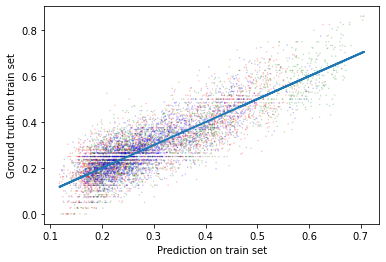

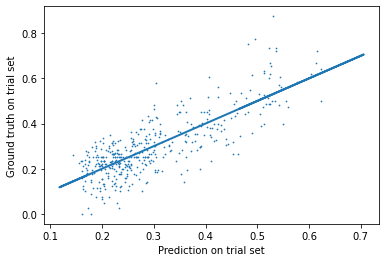

(array([0.16054872, 0.1668253 , 0.162881  , 0.16156373, 0.17798586,
        0.1726198 , 0.17848737, 0.17892128, 0.17054705, 0.20403558,
        0.19610414, 0.20211533, 0.19400472, 0.20251509, 0.19940323,
        0.20040906, 0.1920371 , 0.21364196, 0.21963853, 0.21876603,
        0.18934871, 0.1991305 , 0.19823478, 0.23542393, 0.27640879,
        0.27290543, 0.2826828 , 0.2496753 , 0.20633353, 0.20742509,
        0.18288557, 0.16313227, 0.15472616, 0.22766017, 0.23204749,
        0.23617486, 0.23196838, 0.22537169, 0.20380754, 0.20080596,
        0.20247224, 0.25880447, 0.26476403, 0.28668778, 0.28428404,
        0.28798676, 0.27623334, 0.21882615, 0.23462597, 0.24733608,
        0.21184213, 0.1965783 , 0.21964934, 0.21392123, 0.21332362,
        0.23695207, 0.24854214, 0.24738999, 0.25273676, 0.24970324,
        0.18155489, 0.18640133, 0.30714167, 0.31165082, 0.2261487 ,
        0.19830794, 0.2226095 , 0.22040826, 0.20604673, 0.38899124,
        0.27872004, 0.26542303, 0.26288127, 0.26

In [ ]:
from sklearn.linear_model import RidgeCV, Ridge
from mlxtend.regressor import StackingCVRegressor
estimators=[AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=50),
            LGBMRegressor(num_leaves=40, reg_lambda=100, path_smooth=1, max_depth=10, feature_fraction=0.75, boosting='dart', linear_tree=True,
                                  verbose=0),
            SVR(epsilon=0.01, C=0.1, cache_size=500)]
stacking = StackingCVRegressor(regressors=estimators, meta_regressor=Ridge(alpha=1), 
                             n_jobs=-1, verbose=10, cv=GroupKFold(n_splits=5))
run_experiment(stacking, dim=None) # , 'bible', 'biomed', 'europarl', 'log_freq']) # , ])

In [ ]:
stacking.meta_regr_.coef_

array([0.2987641 , 0.45327695, 0.49084703])

After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
Fitting with StackingCVRegressor; passing groups.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.0s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.1s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.7s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.0s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.1s r

[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.5s remaining:   20.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.6s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.8s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.1s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.1s r

[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.2s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.3s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.7s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.2s remaining:   18.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.2s r

[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.7s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.7s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.7s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.0s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.1s r

[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.4s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.4s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.8s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.1s remaining:   18.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.2s r

[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.4s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.8s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.9s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.9s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.3s remaining:   29.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.6s r

[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

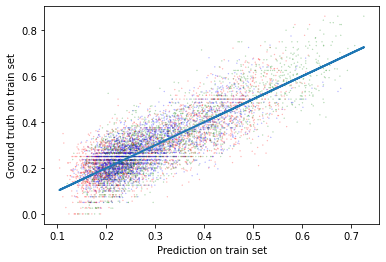

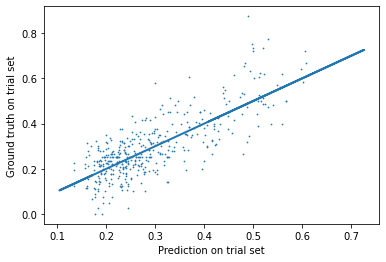

(array([0.17693393, 0.19715832, 0.17720401, 0.18536479, 0.1900732 ,
        0.18313404, 0.17568157, 0.1874692 , 0.1755206 , 0.19304943,
        0.17531285, 0.18437849, 0.17773402, 0.19442383, 0.19268482,
        0.2093787 , 0.19963405, 0.21136512, 0.20527829, 0.20358529,
        0.17660267, 0.20118027, 0.17430609, 0.25529841, 0.27867319,
        0.27586478, 0.29081175, 0.24288311, 0.18243469, 0.18278551,
        0.16097426, 0.13452757, 0.13413426, 0.23254123, 0.22060574,
        0.24108296, 0.24365553, 0.23580636, 0.15993336, 0.1631339 ,
        0.16035883, 0.24312872, 0.25289609, 0.32489995, 0.3176939 ,
        0.32386204, 0.3090491 , 0.18453915, 0.2096523 , 0.24921179,
        0.18201354, 0.16216519, 0.19312541, 0.18257244, 0.16872411,
        0.21014261, 0.23989533, 0.26454928, 0.26676265, 0.25831611,
        0.19473706, 0.19837727, 0.27848649, 0.28615815, 0.19861973,
        0.2128987 , 0.23470093, 0.22833553, 0.20990293, 0.39467394,
        0.27462676, 0.26410903, 0.26706798, 0.26

In [ ]:
from sklearn.linear_model import RidgeCV, Ridge
from mlxtend.regressor import StackingCVRegressor
estimators=[AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=50),
            LGBMRegressor(num_leaves=40, reg_lambda=100, path_smooth=1, max_depth=10, feature_fraction=0.75, boosting='dart', linear_tree=True,
                                  verbose=0),
            SVR(epsilon=0.01, C=0.1, cache_size=500)]
stacking = StackingCVRegressor(regressors=estimators, meta_regressor=Ridge(alpha=1), 
                             n_jobs=-1, verbose=10, cv=GroupKFold(n_splits=5), use_features_in_secondary=True)
run_experiment(stacking, dim=None) # , 'bible', 'biomed', 'europarl', 'log_freq']) # , ])

After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
Fitting with StackingCVRegressor; passing groups.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.4s finished


[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.805134
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.038340
[LightGBM] [Debug] init for col-wise cost 0.000963 seconds, init for row-wise cost 0.005673 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.2s finished


[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.804237
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.038297
[LightGBM] [Debug] init for col-wise cost 0.006988 seconds, init for row-wise cost 0.006327 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s finished


[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.804676
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.038318
[LightGBM] [Debug] init for col-wise cost 0.000971 seconds, init for row-wise cost 0.005691 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.2s finished


[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.804432
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.038306
[LightGBM] [Debug] init for col-wise cost 0.021377 seconds, init for row-wise cost 0.007485 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s finished


[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.802556
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.038217
[LightGBM] [Debug] init for col-wise cost 0.003843 seconds, init for row-wise cost 0.006166 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.6s finished


[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: linear_tree
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.804207
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.038296
[LightGBM] [Debug] init for col-wise cost 0.001160 seconds, init for row-wise cost 0.007737 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

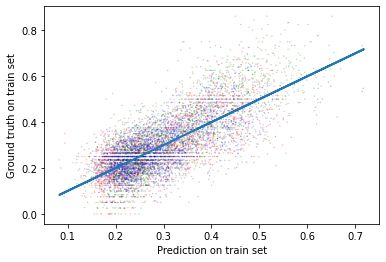

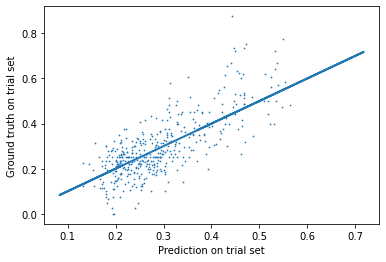

(array([0.1978323 , 0.2154598 , 0.19396186, 0.20609247, 0.19385472,
        0.19209134, 0.18049465, 0.19105191, 0.18276136, 0.182315  ,
        0.17155384, 0.17184507, 0.17409492, 0.18267346, 0.19470586,
        0.21143832, 0.2086013 , 0.20866528, 0.20408547, 0.20061629,
        0.17943407, 0.2067447 , 0.17240892, 0.2737532 , 0.30332835,
        0.30259151, 0.31206784, 0.25309866, 0.19600008, 0.19235082,
        0.16709491, 0.13133176, 0.13133462, 0.25254007, 0.23566385,
        0.26019265, 0.26386539, 0.25640636, 0.15619254, 0.1667125 ,
        0.15695422, 0.25430128, 0.26263064, 0.34161584, 0.33856146,
        0.33964423, 0.33257244, 0.20089468, 0.22624959, 0.26416981,
        0.1994244 , 0.17230993, 0.20438665, 0.19574609, 0.18076021,
        0.23098436, 0.27524804, 0.30122778, 0.30228139, 0.29362118,
        0.21198407, 0.21156522, 0.26877544, 0.27487048, 0.20042234,
        0.23156302, 0.26760292, 0.26112604, 0.21935367, 0.39240761,
        0.29368229, 0.28813525, 0.28939692, 0.29

In [ ]:
from sklearn.linear_model import RidgeCV, Ridge
from mlxtend.regressor import StackingCVRegressor
estimators=[AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=50),
            LGBMRegressor(num_leaves=40, reg_lambda=100, path_smooth=1, max_depth=10, feature_fraction=0.75, boosting='dart', linear_tree=True,
                                  verbose=10),
            SVR(epsilon=0.01, C=0.1, cache_size=500)]
stacking = StackingCVRegressor(regressors=estimators, meta_regressor=Ridge(alpha=1), 
                             n_jobs=-1, verbose=10, cv=GroupKFold(n_splits=3), use_features_in_secondary=True)
run_experiment(stacking, dim=None) # , 'bible', 'biomed', 'europarl', 'log_freq']) # , ])

In [ ]:
stacking.meta_regr_.coef_

array([ 2.17086518e-02,  1.66948238e-01,  5.89770288e-02,  6.92724720e-02,
        4.10107508e-02, -6.39353032e-02, -2.59289444e-02, -2.55354254e-02,
        1.29582631e-04, -5.21301626e-02, -2.90277926e-02,  1.64205060e-02,
        2.54862435e-02,  1.04521535e-02,  2.98769634e-02,  1.24819385e-02,
        1.65870182e-02, -1.68385846e-02, -5.64217069e-03, -9.00469810e-03,
        3.13114756e-02,  1.82164912e-02, -1.97180586e-02, -2.40970117e-03,
       -4.34141869e-03,  1.21925220e-02,  1.78874161e-02,  5.49556421e-04,
       -3.39949931e-03,  3.00941586e-02,  1.05099664e-03, -2.00746727e-02,
        2.23013912e-05, -5.53439683e-03,  2.92171259e-02, -1.79317468e-02,
        1.59692675e-03,  6.46621200e-03, -7.48042217e-03, -7.50719867e-03,
        1.60439772e-03,  3.89134023e-03,  5.76854182e-03,  2.89270142e-04,
        1.36240863e-02, -1.45311273e-03,  2.10285620e-03, -9.32127819e-03,
       -1.65771008e-03,  3.46254406e-03,  2.85993199e-04, -7.33983352e-03,
        2.07713224e-03,  

In [ ]:
from sklearn.linear_model import RidgeCV, Ridge
estimators=[('adaboost1', AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=50)),
            ('adaboost2', AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=100)),
            ('svr1', SVR(epsilon=0.001, C=0.1, cache_size=500)),
            ('svr2', SVR(epsilon=0.01, C=0.1, cache_size=500))]
stacking = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=10), n_jobs=-1)
run_experiment(stacking, dim=None, drop_cols=['freq', 'num_numbers_sent', 'syllables']) # , 'bible', 'biomed', 'europarl', 'log_freq']) # , ])

In [ ]:
from sklearn.linear_model import RidgeCV, Ridge
estimators=[('adaboost1', AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=50)),
            ('adaboost2', AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=100)),
            ('adaboost3', AdaBoostRegressor(DecisionTreeRegressor(max_depth=6), n_estimators=100)),
            ('adaboost4', AdaBoostRegressor(DecisionTreeRegressor(max_depth=7), n_estimators=200)),
            ('adaboost5', AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=50)),
            ('svr1', SVR(epsilon=0.001, C=0.1, cache_size=500)),
            ('svr2', SVR(epsilon=0.01, C=0.1, cache_size=500)),
            ('svr3', SVR(epsilon=0.01, C=0.05, cache_size=500)),]
stacking = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=10), n_jobs=-1, verbose=10)
run_experiment(stacking, dim=None, drop_cols=['freq', 'num_numbers_sent', 'syllables']) # , 'bible', 'biomed', 'europarl', 'log_freq']) # , ])

In [ ]:
from sklearn.linear_model import RidgeCV, Ridge
estimators=[('adaboost1', AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=50)),
            ('adaboost2', AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=100)),
            ('svr1', SVR(epsilon=0.001, C=0.1, cache_size=500)),
            ('svr2', SVR(epsilon=0.01, C=0.1, cache_size=500))]
stacking = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=1), n_jobs=-1)
run_experiment(stacking, dim=None, drop_cols=['freq', 'num_numbers_sent', 'syllables']) # , 'bible', 'biomed', 'europarl', 'log_freq']) # , ])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
def pearsonr_updated(*args):
  return pearsonr(*args)[0]
gcv = GridSearchCV(estimator=AdaBoostRegressor(), param_grid={'base_estimator': [DecisionTreeRegressor(max_depth=n) for n in (2, 4, 6, 8)],
                                                              'n_estimators': [10, 30, 50, 70]},
                   n_jobs=-1, verbose=50, scoring=make_scorer(pearsonr_updated), cv=2)
gcv_tp, gcv_cplx, gcv_train_preds, gcv_train_complexity = run_experiment(gcv, dim=None) # drop_cols=['freq', 'num_numbers_sent', 'syllables'], 'bible', 'biomed', 'europarl', 'log_freq']) # , ])

In [ ]:
pd.DataFrame(gcv.cv_results_)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
def pearsonr_updated(*args):
  return pearsonr(*args)[0]
gcv = GridSearchCV(estimator=AdaBoostRegressor(), param_grid={'base_estimator': [DecisionTreeRegressor(max_depth=n) for n in (6, 8,)],
                                                              'n_estimators': [50, 70],
                                                              'loss': ['linear', 'square', 'exponential']},
                   n_jobs=-1, verbose=50, scoring=make_scorer(pearsonr_updated), cv=2)
gcv_tp, gcv_cplx, gcv_train_preds, gcv_train_complexity = run_experiment(gcv, dim=None) # drop_cols=['freq', 'num_numbers_sent', 'syllables'], 'bible', 'biomed', 'europarl', 'log_freq']) # , ])

In [ ]:
pd.DataFrame(gcv.cv_results_)

Attempting more different models


After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
Cross-val: 0.7525252838297596 [0.7459454930191957, 0.7538390484107619, 0.7530320406675587, 0.7405109161468114, 0.7692989209044704]
Fitting a single regressor.
Train R (0.7672878582433503, 0.0)
Train L1: 0.06660091385126299
Trial R (0.7689817780764436, 1.9314268240673212e-83)
Trial L1: 0.06750915646299233
bible (0.7256937066867858, 1.1605986516273945e-24)
biomed (0.7854285441316056, 1.70814429158033e-29)
europarl (0.7281234798235382, 6.8222909852738395e-25)


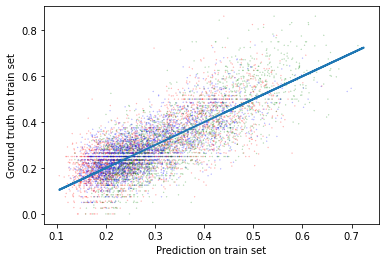

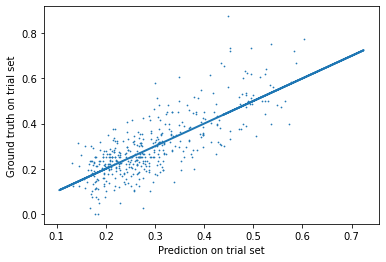

(array([0.18409065, 0.19986733, 0.1783642 , 0.19520336, 0.17689882,
        0.16809381, 0.17059682, 0.1616279 , 0.16350371, 0.18669661,
        0.17979287, 0.17311999, 0.17688577, 0.17846072, 0.17100475,
        0.18198516, 0.17657847, 0.19908454, 0.1968435 , 0.18521973,
        0.1795284 , 0.20874695, 0.16722457, 0.25702964, 0.28967046,
        0.28711874, 0.29688375, 0.21701771, 0.18308121, 0.18723176,
        0.157736  , 0.1337442 , 0.13121495, 0.26658401, 0.24925581,
        0.27426526, 0.2761554 , 0.26835152, 0.14513903, 0.15575362,
        0.14379218, 0.26128007, 0.27185517, 0.29500206, 0.30377557,
        0.2949743 , 0.29508545, 0.18022768, 0.21273739, 0.27634645,
        0.17657802, 0.14600321, 0.18145001, 0.17303253, 0.15837307,
        0.22905027, 0.26419895, 0.28678027, 0.28710902, 0.27939918,
        0.19590081, 0.18711283, 0.26664248, 0.26865433, 0.22038184,
        0.20702044, 0.24009925, 0.23508818, 0.21135052, 0.37984813,
        0.27766973, 0.26466801, 0.26768484, 0.26

In [ ]:
# from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
model = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model)

After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
Cross-val: 0.7550456640372356 [0.7555745127434089, 0.750369479547795, 0.7581591042019983, 0.7495355763571544, 0.7615896473358212]
Fitting a single regressor.
Train R (0.7624122205938421, 0.0)
Train L1: 0.06683753745344673
Trial R (0.7800259579448099, 2.448705034521927e-87)
Trial L1: 0.06735831050911548
bible (0.7247529783485389, 1.4235051621385992e-24)
biomed (0.8124590887669466, 5.800649795655064e-33)
europarl (0.7140884151777, 1.3602444974068968e-23)


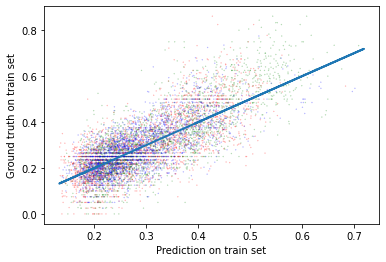

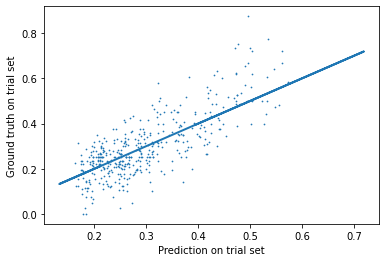

(array([0.17753695, 0.18589746, 0.17548588, 0.17866034, 0.18449349,
        0.18129232, 0.17695755, 0.18311484, 0.17463768, 0.19602279,
        0.18801933, 0.19214554, 0.18929568, 0.19666223, 0.19353847,
        0.20110755, 0.1970972 , 0.23593969, 0.23112215, 0.23281405,
        0.18356337, 0.19672196, 0.19470096, 0.26274527, 0.3111514 ,
        0.30490221, 0.31309147, 0.25583576, 0.21631572, 0.21690043,
        0.18228423, 0.16418085, 0.16203048, 0.25469308, 0.25094833,
        0.26097008, 0.26423761, 0.25616093, 0.16849707, 0.16894882,
        0.16880024, 0.26338674, 0.26991899, 0.30661582, 0.30455409,
        0.30626125, 0.29801972, 0.22323282, 0.24497102, 0.26752985,
        0.21793986, 0.19771095, 0.2263118 , 0.21654547, 0.21258648,
        0.24871132, 0.26897926, 0.28730385, 0.28736937, 0.2800093 ,
        0.17410211, 0.19863146, 0.28936409, 0.28627268, 0.22837064,
        0.21356139, 0.25765455, 0.25205073, 0.21938107, 0.38843546,
        0.29857687, 0.29207083, 0.28962361, 0.29

In [ ]:
model = Lasso(alpha=0.01)
run_experiment(model)

In [ ]:
# from sklearn import linear_model
# model = linear_model.ARDRegression()
# run_experiment(model)

After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)


KeyboardInterrupt: ignored

After dropping (7662, 126)
Index(['glove0', 'glove1', 'glove2', 'glove3', 'glove4', 'glove5', 'glove6',
       'glove7', 'glove8', 'glove9',
       ...
       'syllables', 'bible', 'biomed', 'biomed-long', 'biomed-numbers',
       'sentence_len', 'len_token', 'first_letter_is_capital', 'is_propn',
       'is_ner'],
      dtype='object', length=126)
Cross-val: 0.74415242003668 [0.7445937329816096, 0.7437291724774828, 0.7436234958538687, 0.7329533750490116, 0.7558623238214274]
Fitting a single regressor.
Train R (0.8605626676906227, 0.0)
Train L1: 0.05712580508626338
Trial R (0.7766566195648437, 3.994506452755956e-86)
Trial L1: 0.06699424858824557
bible (0.7286025971760641, 6.139532497015673e-25)
biomed (0.8203132990385353, 4.453445906013601e-34)
europarl (0.6891723032848117, 1.8138031130872057e-21)


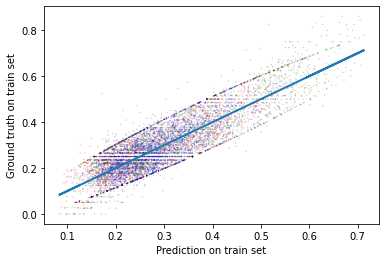

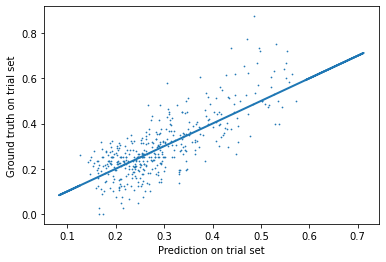

(array([0.16536992, 0.17527487, 0.16945107, 0.1633473 , 0.17452625,
        0.16553337, 0.17117646, 0.17747741, 0.161908  , 0.21054415,
        0.18704261, 0.20850755, 0.19387366, 0.21158302, 0.21267433,
        0.20930078, 0.18791426, 0.25618129, 0.25248282, 0.26410801,
        0.1995768 , 0.1923766 , 0.18660291, 0.2697959 , 0.26065048,
        0.23733517, 0.25464792, 0.23704359, 0.21945681, 0.22324312,
        0.15966796, 0.16320862, 0.15426877, 0.23068423, 0.2473931 ,
        0.24568162, 0.24790414, 0.23447483, 0.21073961, 0.19674486,
        0.20630955, 0.2545604 , 0.27268056, 0.28900924, 0.28498638,
        0.29887944, 0.26628852, 0.25645522, 0.28211825, 0.25052384,
        0.193592  , 0.18297679, 0.22738109, 0.20593669, 0.2187775 ,
        0.22582897, 0.23412304, 0.25792767, 0.26227834, 0.24707992,
        0.18327744, 0.16934165, 0.28817626, 0.28994061, 0.24721174,
        0.19852363, 0.25641895, 0.23745382, 0.23260554, 0.34665297,
        0.27509908, 0.25447767, 0.25414625, 0.26

In [ ]:
from sklearn.svm import NuSVR
model = NuSVR(nu=0.1)
run_experiment(model)
